In [1]:
import sys
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Administrator\Anaconda3\envs\Code\lib\site-

# 1 Read facies images generated from Trianing GAN

##### Set the path to directory containing code of this case

In [2]:
new_path = 'H:/02Article/004MudDrapesModeling/005GeoModeling_Conditional_to_Probability_maps_plus-master_nolabel/GeoModeling_Conditional_to_Probability_maps_plus-master/Code/5-Upload_cond_well_globalfeatures_probmap/' 
sys.path.append(new_path)

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [3]:
data_dir_test = 'H:/02Article/004MudDrapesModeling(WRR)/003Four_type_Datasets/004Four_facies_condition/'

#### Set path to trained network

In [4]:
network_dir = 'H:/02Article/004MudDrapesModeling(WRR)/007RevisingManuscript/ConditionalData6/000-pgan-2gpu-0.451CondWell-Enlarg-0.25CondProb/'
network_name = 'network-snapshot-014080.pkl'

### 1. Fetch dataset

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

fm_no = 40

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestingData', labeltypes = [], well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

realcubes_test, labels_test = test_set.get_minibatch_imageandlabel_np(fm_no) 
probcubes_test, wellfaciescubes_test = test_set.get_minibatch_probandwell_np(fm_no)
realcubes_test = realcubes_test/255

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Colocations handled automatically by placer.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 255]
Label size    = 0


In [6]:
print(realcubes_test.shape)
print(labels_test.shape)
print(probcubes_test.shape)
print(wellfaciescubes_test.shape)

(40, 1, 64, 64)
(40, 0)
(40, 1, 64, 64)
(40, 1, 64, 64)


In [7]:
allimgs_max = np.max(realcubes_test, axis = (2, 3), keepdims = True)
allimgs_min = np.min(realcubes_test, axis = (2, 3), keepdims = True)
realcubes_test = (realcubes_test - allimgs_min)/(allimgs_max - allimgs_min)

In [8]:
realcubes_test.shape

(40, 1, 64, 64)

### 2. Import pre-trained Network

In [9]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)
    
del G

C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 3. Evaluation on 64x64 synthetic cases

##### (1) Get synthetic channel model (groundtruth model; i.e., the 9th model in test_set) 

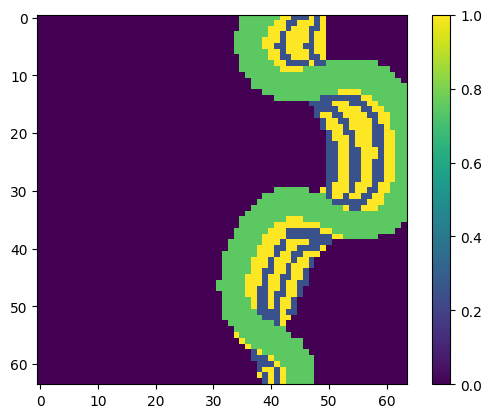

In [10]:
synmodel1 = realcubes_test[19:20]
plt.imshow(synmodel1[0,0,:,:])
plt.colorbar()

##### (2) Get probability map

In [11]:
from scipy.stats import multivariate_normal
def norm_kernel(size = 9, sigma = 2):
    sig = sigma * np.eye(2)
    mean = np.zeros(2,)
    size_min = -(size - 1)/2
    size_max = (size - 1)/2
    x = np.linspace(size_min, size_max, size)
    y = np.linspace(size_min, size_max, size)
    xk, yk = np.meshgrid(x, y)
    kernel = np.zeros((size,size), dtype=np.float32)
    for i in range(size):
        for j in range(size):
            coord = np.squeeze([xk[i,j], yk[i,j]])
            kernel[i,j] = multivariate_normal.pdf(coord, mean=mean, cov=sig)
    kernel_sum = np.sum(kernel)
    kernel = kernel / kernel_sum
    return kernel

In [12]:
import scipy.signal as sig
prob_rlzs = np.zeros(([realcubes_test.shape[0]]+[*realcubes_test.shape[1:]]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]
# count = 0
for i in range (fm_no):
    synmodel1_copy = np.zeros((64,64), dtype=np.float32)
    synmodel1_copy = realcubes_test[i,0]
    probcube = np.zeros((1, 1, 64, 64), dtype=np.float32) 
    k = 15
    kernel = norm_kernel(size = k, sigma = k)  # size should be set to be odd
    synprob1 = np.zeros((1,1,64,64), dtype=np.float32)
    padvalue = np.mean(synmodel1)
    prob_cube = sig.convolve2d(synmodel1_copy, kernel, fillvalue = padvalue, mode='same')
    synprob1[0, 0] = prob_cube
    prob_rlzs[i, 0] = prob_cube

In [13]:
prob_rlzs_max = np.max(prob_rlzs, axis = (2, 3), keepdims = True)
prob_rlzs_min = np.min(prob_rlzs, axis = (2, 3), keepdims = True)
prob_rlzs = (prob_rlzs - prob_rlzs_min)/(prob_rlzs_max - prob_rlzs_min)

In [14]:
prob_rlzs.shape

(40, 1, 64, 64)

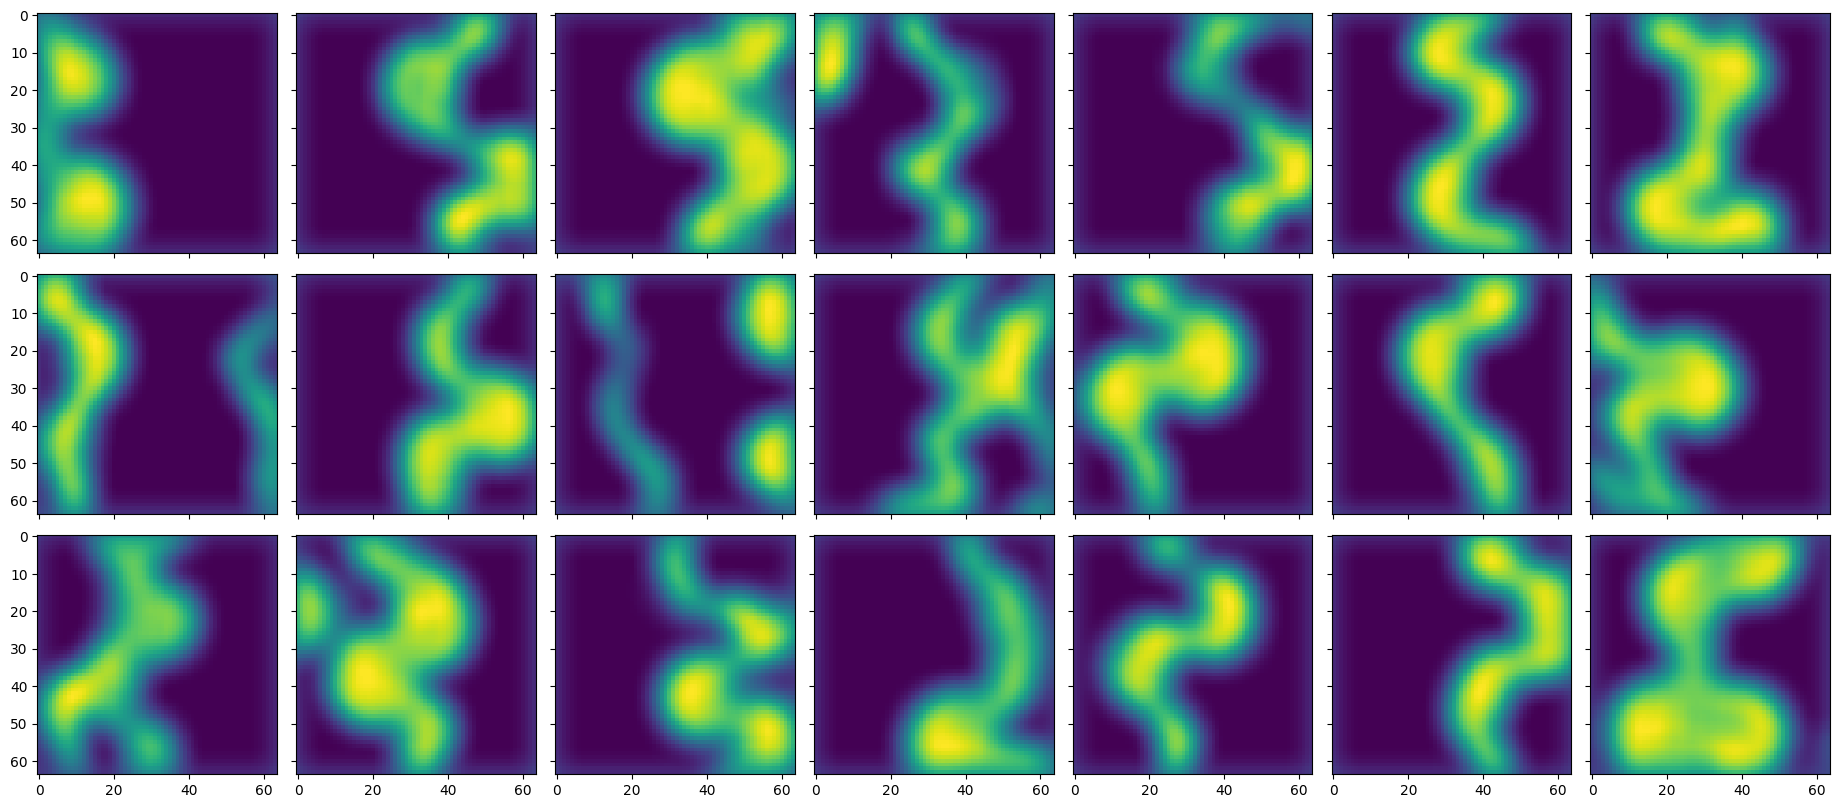

In [15]:
fig, ax = plt.subplots(3, 7, sharex='col', sharey='row')
fig.set_size_inches(18.5, 8.2, forward=True)
  
for i in range (3):
    for j in range(7):
        ax[i, j].imshow(prob_rlzs[(7*i+j), 0,:,:])
    
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.08, hspace=0.04)

##### (3) Sample well facies from the theoretical facies model

In [16]:
# Determine the number of each facies
def samplewells(cube, cavewellnumber, noncavewellnumber):
    wellfacies = np.ones(cube.shape)*(-99)
    cave_indices = np.argwhere(cube>=0.2)
    cave_wells_indices = np.random.RandomState(1301).randint(0, cave_indices.shape[0], cavewellnumber) 
    cave_wells_coos = cave_indices[cave_wells_indices]
    wellfacies[0,0,cave_wells_coos[:, 2], cave_wells_coos[:, 3]] = cube[0,0,cave_wells_coos[:, 2], cave_wells_coos[:, 3]]

    noncave_indices = np.argwhere(cube<=0.1)
    noncave_wells_indices = np.random.RandomState(3136).randint(0, noncave_indices.shape[0], noncavewellnumber) 
    noncave_wells_coos = noncave_indices[noncave_wells_indices]
    wellfacies[0,0,noncave_wells_coos[:, 2], noncave_wells_coos[:, 3]] = cube[0,0,noncave_wells_coos[:, 2], noncave_wells_coos[:, 3]]

    return wellfacies

In [17]:
Well_rlzs = np.zeros(([realcubes_test.shape[0]]+[*realcubes_test.shape[1:]]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]
synmodel1 = np.zeros(([realcubes_test.shape[1]]+[*realcubes_test.shape[1:]]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]
for i in range (fm_no):
    synmodel1[0,0] = realcubes_test[i,0]
    well_points_NonBackgroundMudnum = np.random.RandomState(1301+i*300).choice(np.arange(1, 6), 1)
    well_points_BackgroundMudnum = np.random.RandomState(1301+i*300).choice(np.arange(1, 6), 1)
    synwellfacies1 = samplewells(synmodel1, well_points_NonBackgroundMudnum, well_points_BackgroundMudnum)
    Well_rlzs[i, 0] = synwellfacies1

In [18]:
synmodel1 = realcubes_test[19:20]
synwellfacies1 = samplewells(synmodel1, 4, 6)
Well_rlzs[19, 0] = synwellfacies1

In [19]:
print(synmodel1.shape)
print(Well_rlzs.shape)

(1, 1, 64, 64)
(40, 1, 64, 64)


In [20]:
syn_wellpoints1 = np.where(Well_rlzs == -99, 0, 1)
syn_welltypes1 = np.where(Well_rlzs == -99, 0, Well_rlzs)
syn_wellfacies_input1 = np.concatenate([syn_wellpoints1, syn_welltypes1], 1)      
print(syn_wellfacies_input1.shape)

(40, 2, 64, 64)


In [21]:
### Enlarge areas of well points into 4 x 4 as inputs

syn_wellfacies_input1 = syn_wellfacies_input1.astype(np.float32)
# plt.imshow(syn_wellfacies_input1[0,0,:,:])

with tf.device('/gpu:0'):
    syn_wellfacies_input1 = tf.transpose(syn_wellfacies_input1, perm=[0, 2, 3, 1])
    syn_wellfacies_input1_enlarge = tf.nn.max_pool(syn_wellfacies_input1, ksize = [1,1,1,1], strides=[1,1,1,1], padding='SAME', data_format='NHWC')
    syn_wellfacies_input1_enlarge = tf.transpose(syn_wellfacies_input1_enlarge, perm=[0, 3, 1, 2])

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    syn_wellfacies_input1_el = sess.run(syn_wellfacies_input1_enlarge)

syn_wellfacies_input1_el[:,1:2] = np.where(syn_wellfacies_input1_el[:,1:2] > 0.8, 1, syn_wellfacies_input1_el[:,1:2])
syn_wellfacies_input1_el[:,1:2] = np.where((syn_wellfacies_input1_el[:,1:2] > 0.5) & (syn_wellfacies_input1_el[:,1:2] < 0.8), 0.75, syn_wellfacies_input1_el[:,1:2])
syn_wellfacies_input1_el[:,1:2] = np.where((syn_wellfacies_input1_el[:,1:2] > 0.2) & (syn_wellfacies_input1_el[:,1:2] < 0.5), 0.25, syn_wellfacies_input1_el[:,1:2])
syn_wellfacies_input1_el[:,1:2] = np.where(syn_wellfacies_input1_el[:,1:2] < 0.2, 0, syn_wellfacies_input1_el[:,1:2])

# make mask of output well facies data 
syn_wellfacies_input1_el_onechannel = syn_wellfacies_input1_el[:,0:1]+syn_wellfacies_input1_el[:,1:2]

syn_wellfacies_input1_el_onechannel_mask = np.ma.masked_where(syn_wellfacies_input1_el_onechannel == 0, syn_wellfacies_input1_el_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()


In [22]:
print(syn_wellfacies_input1_el.shape)

(40, 2, 64, 64)


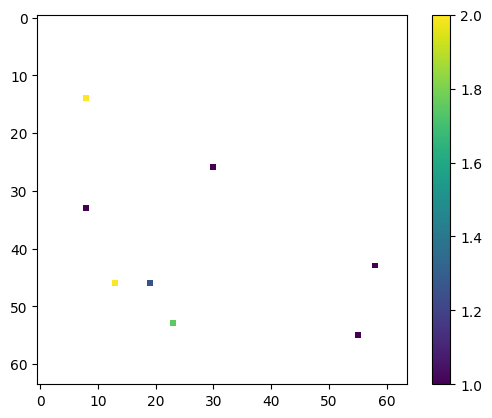

In [23]:
plt.imshow(syn_wellfacies_input1_el_onechannel_mask[0,0,:,:])
plt.colorbar()

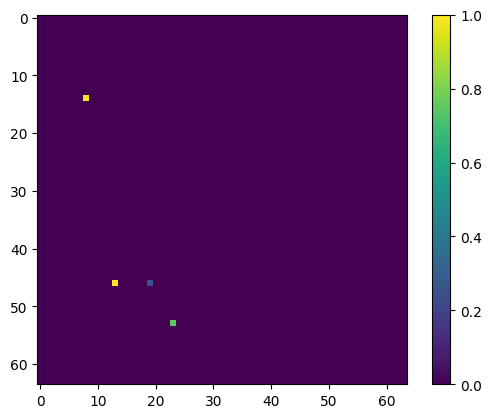

In [24]:
plt.imshow(syn_wellfacies_input1_el[0,1,:,:], vmin=0, vmax=1)
plt.colorbar()

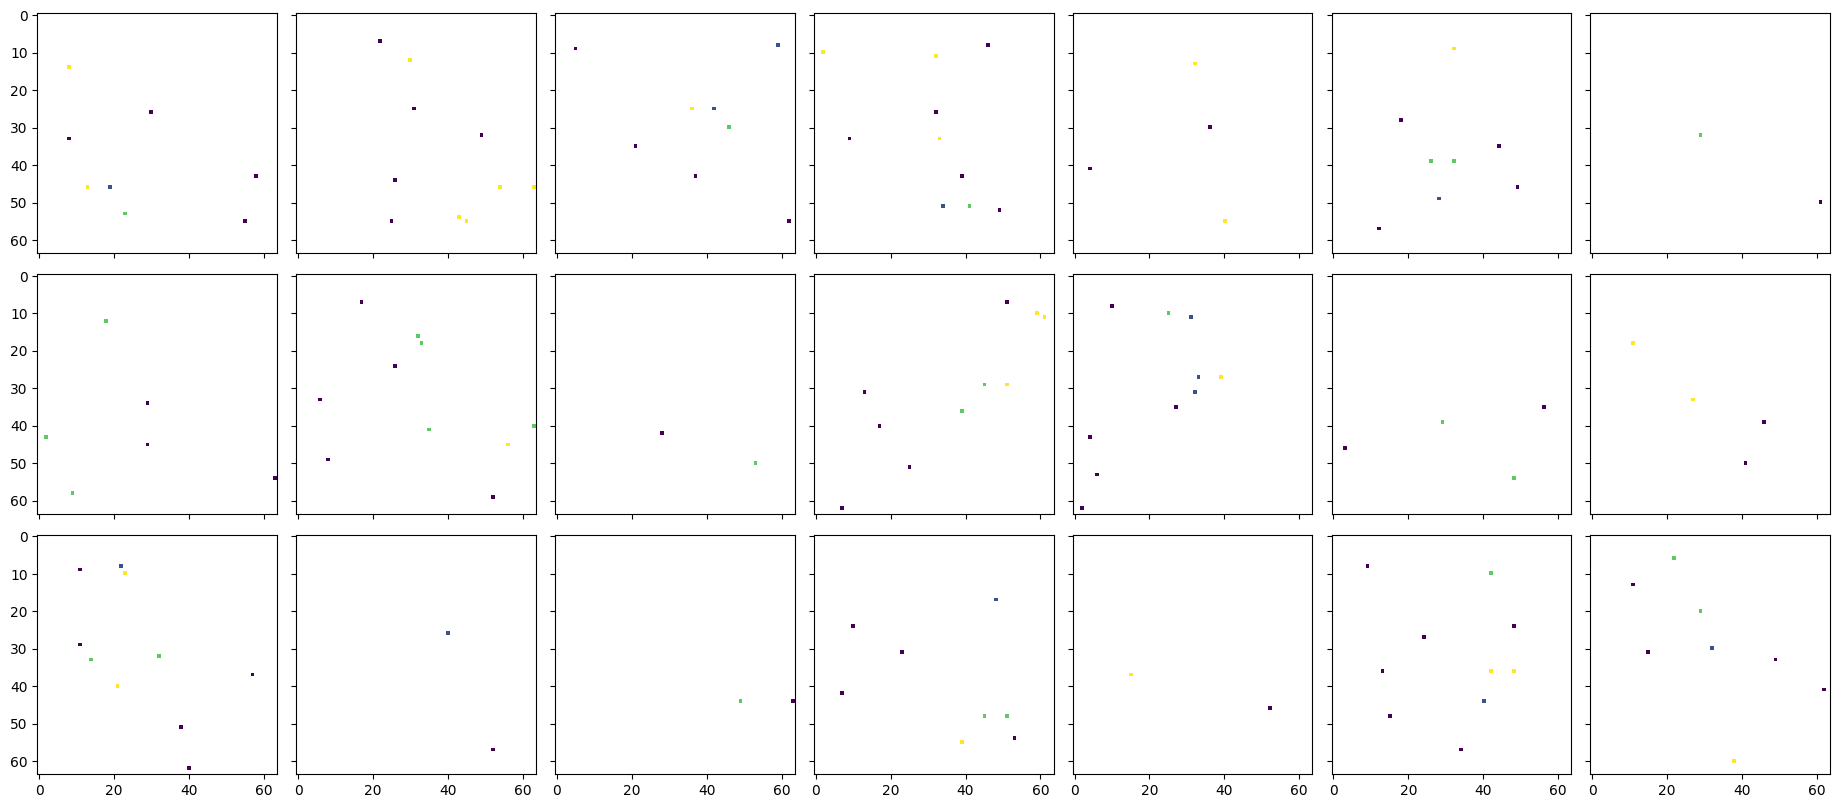

In [25]:
fig, ax = plt.subplots(3, 7, sharex='col', sharey='row')
fig.set_size_inches(18.5, 8.2, forward=True)
  
for i in range (3):
    for j in range(7):
        ax[i, j].imshow(syn_wellfacies_input1_el_onechannel_mask[(7*i+j), 0,:,:], vmin=1, vmax=2)
    
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.08, hspace=0.04)

# 6. Generate channel models using trained generator

In [26]:
Num_of_conditioning_data = np.array([0,11,12,17,34,5,6,38,19])

In [27]:
Num_of_conditioning_data.shape[0]

9

In [28]:
print(Gs.input_shapes)

[[None, 128], [None, 2, 64, 64], [None, 1, 64, 64]]


In [29]:
print(synmodel1.shape)
print(synprob1.shape)
print(syn_wellfacies_input1_el.shape)

(1, 1, 64, 64)
(1, 1, 64, 64)
(40, 2, 64, 64)


In [30]:
TotalReal_no = 500
Fakemodels_final = np.zeros(([fm_no]+[TotalReal_no]+[*realcubes_test.shape[1:]]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]
synprob1 = np.zeros(([1]+[*realcubes_test.shape[1:]]), dtype=np.float32)
syn_wellfacies_input1_el_one = np.zeros(([1]+[2]+[*realcubes_test.shape[2:]]), dtype=np.float32)
syn_wellfacies_input1_el_mult = np.zeros(([40]+[2]+[*realcubes_test.shape[2:]]), dtype=np.float32)

for j in range(Num_of_conditioning_data.shape[0]):
    condfakemodels = np.zeros([TotalReal_no, 1, 64, 64])
    latents = np.random.RandomState(412).randn(TotalReal_no, 128)   #
    for i in range(int(TotalReal_no/40)):
        latents1 = latents[i*40:(i+1)*40]
        syn_wellfacies_input1_el_one[0] = syn_wellfacies_input1_el[Num_of_conditioning_data[j]]
        synprob1[0] = prob_rlzs[Num_of_conditioning_data[j]]
        syn_wellfacies_input1_el_mult = np.repeat(syn_wellfacies_input1_el_one, 40, axis=0)
        synprob1_mult = np.repeat(synprob1, 40, axis=0)
        fakemodels = Gs.run(latents1, syn_wellfacies_input1_el_mult, synprob1_mult)
        fakemodels_max = np.max(fakemodels, axis = (2, 3), keepdims = True)
        fakemodels_min = np.min(fakemodels, axis = (2, 3), keepdims = True)
        fakemodels = (fakemodels - fakemodels_min)/(fakemodels_max - fakemodels_min)
        fakemodels = np.where(fakemodels<0.15, 0, fakemodels)
        fakemodels = np.where((fakemodels>= 0.15) & (fakemodels<0.50), 0.25, fakemodels)
        fakemodels = np.where((fakemodels>= 0.50) & (fakemodels<0.85), 0.75, fakemodels)
        fakemodels = np.where(fakemodels>= 0.85, 1, fakemodels)
        condfakemodels[i*40:(i+1)*40] = fakemodels
        Fakemodels_final[Num_of_conditioning_data[j],i*40:(i+1)*40] = condfakemodels[i*40:(i+1)*40]

In [31]:
print(condfakemodels.shape)

(500, 1, 64, 64)


In [32]:
Well_rlzs = np.zeros(([realcubes_test.shape[0]]+[*realcubes_test.shape[1:]]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]
synmodel1 = np.zeros(([realcubes_test.shape[1]]+[*realcubes_test.shape[1:]]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]
for i in range (fm_no):
    synmodel1[0,0] = realcubes_test[i,0]
    well_points_NonBackgroundMudnum = np.random.RandomState(1301+i*300).choice(np.arange(1, 6), 1)
    well_points_BackgroundMudnum = np.random.RandomState(1301+i*300).choice(np.arange(1, 6), 1)
    synwellfacies1 = samplewells(synmodel1, well_points_NonBackgroundMudnum, well_points_BackgroundMudnum)
    Well_rlzs[i, 0] = synwellfacies1

In [33]:
synmodel1 = realcubes_test[19:20]
synwellfacies1 = samplewells(synmodel1, 4, 6)
Well_rlzs[19, 0] = synwellfacies1

In [34]:
syn_wellpoints1 = np.where(Well_rlzs == -99, 0, 1)
syn_welltypes1 = np.where(Well_rlzs == -99, 0, Well_rlzs)
syn_wellfacies_input1 = np.concatenate([syn_wellpoints1, syn_welltypes1], 1)      
print(syn_wellfacies_input1.shape)

(40, 2, 64, 64)


In [35]:
### Enlarge areas of well points into 4 x 4 as inputs

syn_wellfacies_input1 = syn_wellfacies_input1.astype(np.float32)

with tf.device('/gpu:0'):
    syn_wellfacies_input1 = tf.transpose(syn_wellfacies_input1, perm=[0, 2, 3, 1])
    syn_wellfacies_input1_enlarge = tf.nn.max_pool(syn_wellfacies_input1, ksize = [1,1,1,1], strides=[1,1,1,1], padding='SAME', data_format='NHWC')
    syn_wellfacies_input1_enlarge = tf.transpose(syn_wellfacies_input1_enlarge, perm=[0, 3, 1, 2])

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    syn_wellfacies_input1_el = sess.run(syn_wellfacies_input1_enlarge)

# make mask of output well facies data 
syn_wellfacies_input1_el_onechannel = syn_wellfacies_input1_el[:,0:1]+syn_wellfacies_input1_el[:,1:2]
syn_wellfacies_input1_el_onechannel_mask = np.ma.masked_where(syn_wellfacies_input1_el_onechannel == 0, syn_wellfacies_input1_el_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()


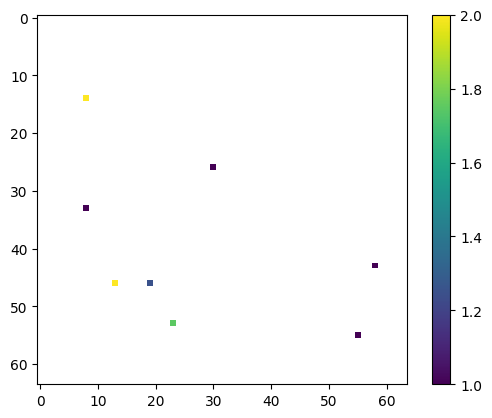

In [36]:
plt.imshow(syn_wellfacies_input1_el_onechannel_mask[0,0,:,:])
plt.colorbar()

In [37]:
# syn_wellfacies_input1_el_onechannel_mask = syn_wellfacies_input1_el_onechannel_mask-1
well_data = np.zeros([fm_no, 1, 64, 64])
for i in range(fm_no):
    well_data[i,0] = np.where(syn_wellfacies_input1_el[i,0] == 0, -99, syn_wellfacies_input1_el[i,1])
    well_data = np.where(well_data > 0.8, 1, well_data)
    well_data = np.where((well_data > 0.5) & (well_data < 0.8), 0.75, well_data)
    well_data = np.where((well_data > 0.2) & (well_data < 0.5), 0.25, well_data)

In [38]:
def hamming(x, y):
    return np.sum(x == y)

In [39]:
well_data = np.where(well_data > 0.8, 1, well_data)
well_data = np.where((well_data > 0.5) & (well_data < 0.8), 0.75, well_data)
well_data = np.where((well_data > 0.2) & (well_data < 0.5), 0.25, well_data)
well_data = np.where((well_data >= 0) & (well_data < 0.2), 0, well_data)

In [40]:
hamming(well_data[12,0], Fakemodels_final[12,1])

4

In [41]:
Fakemodels_match_well = np.zeros([Num_of_conditioning_data.shape[0],13,TotalReal_no,64, 64])
Num_match_well = np.zeros([40,13], dtype=np.int)*0
for kk in range(Num_of_conditioning_data.shape[0]):
    for num in range(sum(sum(well_data[Num_of_conditioning_data[kk],0]>-1))+1):
        Num_match_well[Num_of_conditioning_data[kk],num] = 0
        for i in range(TotalReal_no):  
            if hamming(well_data[Num_of_conditioning_data[kk],0], Fakemodels_final[Num_of_conditioning_data[kk],i]) == num:
                Fakemodels_match_well[kk,num,Num_match_well[Num_of_conditioning_data[kk],num]] = Fakemodels_final[Num_of_conditioning_data[kk],i]
                Num_match_well[Num_of_conditioning_data[kk],num] = Num_match_well[Num_of_conditioning_data[kk],num]+1
Num_match_well = Num_match_well/TotalReal_no

C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [42]:
MPS_Num_match_well = np.zeros([40,13])
for kk in range(Num_of_conditioning_data.shape[0]):
    for num in range(sum(sum(well_data[Num_of_conditioning_data[kk],0]>-1))+1):
        for i in range(TotalReal_no):  
            if num == sum(sum(well_data[Num_of_conditioning_data[kk],0]>-1)):
                MPS_Num_match_well[Num_of_conditioning_data[kk],num] = 1

In [43]:
Num_match_well[0]

array([0.   , 0.   , 0.   , 0.004, 0.048, 0.008, 0.07 , 0.288, 0.582,
       0.   , 0.   , 0.   , 0.   ])

In [44]:
Num_match_well.shape

(40, 13)

In [45]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.-0.2, 1.03*height, '%7.4s' % float(height))

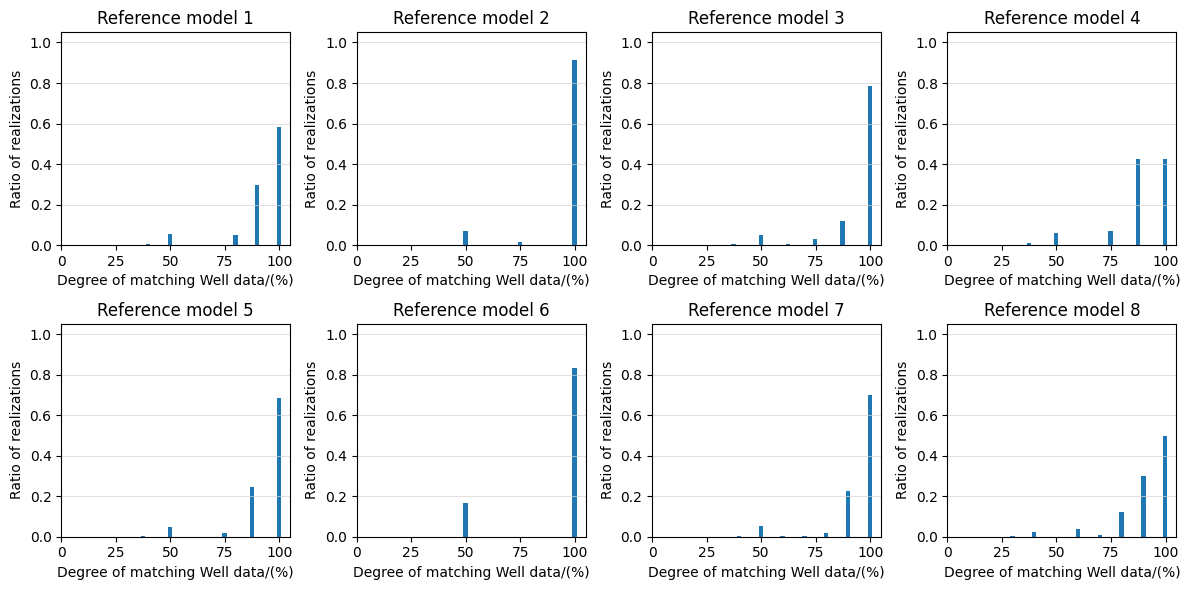

In [46]:
fig, ax = plt.subplots(2, 4, sharex=False, sharey=False)
fig.set_size_inches(12, 6, forward=True)


plt.subplot(241)
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])/10*100
plt.bar(x-0.17,Num_match_well[11], width = 2)
ax[0,0].set_xlim(0,105)
ax[0,0].set_ylim(0,1.05)
ax[0,0].set_title('Reference model 1')
ax[0,0].set_ylabel('Ratio of realizations')
ax[0,0].set_xlabel('Degree of matching Well data/(%)')
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='lightgray')
plt.grid(axis='x', linestyle='-', linewidth=0)

plt.subplot(242)
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])/4*100
plt.bar(x-0.17,Num_match_well[12], width = 2)
ax[0,1].set_xlim(0,105)
ax[0,1].set_ylim(0,1.05)
ax[0,1].set_title('Reference model 2')
ax[0,1].set_ylabel('Ratio of realizations')
ax[0,1].set_xlabel('Degree of matching Well data/(%)')
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='lightgray')

plt.grid(axis='x', linestyle='-', linewidth=0)

plt.subplot(243)
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])/8*100
plt.bar(x-0.17,Num_match_well[17], width = 2)
ax[0,2].set_xlim(0,105)
ax[0,2].set_ylim(0,1.05)
ax[0,2].set_title('Reference model 3')
#ax[0,0].set_xlabel('Facies proportion')
ax[0,2].set_ylabel('Ratio of realizations')
ax[0,2].set_xlabel('Degree of matching Well data/(%)')
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='lightgray')

plt.grid(axis='x', linestyle='-', linewidth=0)


plt.subplot(244)
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])/8*100
plt.bar(x-0.17,Num_match_well[34], width = 2)
ax[0,3].set_xlim(0,105)
ax[0,3].set_ylim(0,1.05)
ax[0,3].set_title('Reference model 4')
ax[0,3].set_ylabel('Ratio of realizations')
ax[0,3].set_xlabel('Degree of matching Well data/(%)')
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='lightgray')

plt.grid(axis='x', linestyle='-', linewidth=0)


plt.subplot(245)
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])/8*100
plt.bar(x-0.17,Num_match_well[5], width = 2)
ax[1,0].set_xlim(0,105)
ax[1,0].set_ylim(0,1.05)
ax[1,0].set_title('Reference model 5')
ax[1,0].set_ylabel('Ratio of realizations')
ax[1,0].set_xlabel('Degree of matching Well data/(%)')
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='lightgray')

plt.grid(axis='x', linestyle='-', linewidth=0)


plt.subplot(246)
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])/2*100
plt.bar(x-0.17,Num_match_well[6], width = 2)
ax[1,1].set_xlim(0,105)
ax[1,1].set_ylim(0,1.05)
ax[1,1].set_title('Reference model 6')
ax[1,1].set_ylabel('Ratio of realizations')
ax[1,1].set_xlabel('Degree of matching Well data/(%)')
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='lightgray')

plt.grid(axis='x', linestyle='-', linewidth=0)


plt.subplot(247)
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])/10*100
plt.bar(x-0.17,Num_match_well[38], width = 2)
ax[1,2].set_xlim(0,105)
ax[1,2].set_ylim(0,1.05)
ax[1,2].set_title('Reference model 7')
ax[1,2].set_ylabel('Ratio of realizations')
ax[1,2].set_xlabel('Degree of matching Well data/(%)')
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='lightgray')
plt.grid(axis='x', linestyle='-', linewidth=0)

plt.subplot(248)
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])/10*100
results1 = plt.bar(x-0.17,Num_match_well[19], width = 2)
ax[1,3].set_xlim(0,105)
ax[1,3].set_ylim(0,1.05)
ax[1,3].set_title('Reference model 8')
ax[1,3].set_ylabel('Ratio of realizations')
ax[1,3].set_xlabel('Degree of matching Well data/(%)')
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='lightgray')
plt.grid(axis='x', linestyle='-', linewidth=0)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=0.29, hspace=0.37)


In [47]:
Well_rlzs = np.zeros(([realcubes_test.shape[0]]+[*realcubes_test.shape[1:]]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]
synmodel1 = np.zeros(([realcubes_test.shape[1]]+[*realcubes_test.shape[1:]]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]
for i in range (fm_no):
    synmodel1[0,0] = realcubes_test[i,0]
    well_points_NonBackgroundMudnum = np.random.RandomState(1301+i*300).choice(np.arange(1, 6), 1)
    well_points_BackgroundMudnum = np.random.RandomState(1301+i*300).choice(np.arange(1, 6), 1)
    synwellfacies1 = samplewells(synmodel1, well_points_NonBackgroundMudnum, well_points_BackgroundMudnum)
    Well_rlzs[i, 0] = synwellfacies1

In [48]:
synmodel1 = realcubes_test[19:20]
synwellfacies1 = samplewells(synmodel1, 4, 6)
Well_rlzs[19, 0] = synwellfacies1

In [49]:
syn_wellpoints1 = np.where(Well_rlzs == -99, 0, 1)
syn_welltypes1 = np.where(Well_rlzs == -99, 0, Well_rlzs)
syn_wellfacies_input1 = np.concatenate([syn_wellpoints1, syn_welltypes1], 1)      
print(syn_wellfacies_input1.shape)

(40, 2, 64, 64)


In [50]:
### Enlarge areas of well points into 4 x 4 as inputs

syn_wellfacies_input1 = syn_wellfacies_input1.astype(np.float32)
# plt.imshow(syn_wellfacies_input1[0,0,:,:])

with tf.device('/gpu:0'):
    syn_wellfacies_input1 = tf.transpose(syn_wellfacies_input1, perm=[0, 2, 3, 1])
    syn_wellfacies_input1_enlarge = tf.nn.max_pool(syn_wellfacies_input1, ksize = [1,2,2,1], strides=[1,1,1,1], padding='SAME', data_format='NHWC')
    syn_wellfacies_input1_enlarge = tf.transpose(syn_wellfacies_input1_enlarge, perm=[0, 3, 1, 2])

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    syn_wellfacies_input1_el = sess.run(syn_wellfacies_input1_enlarge)

syn_wellfacies_input1_el[:,1:2] = np.where(syn_wellfacies_input1_el[:,1:2] > 0.8, 1, syn_wellfacies_input1_el[:,1:2])
syn_wellfacies_input1_el[:,1:2] = np.where((syn_wellfacies_input1_el[:,1:2] > 0.5) & (syn_wellfacies_input1_el[:,1:2] < 0.8), 0.75, syn_wellfacies_input1_el[:,1:2])
syn_wellfacies_input1_el[:,1:2] = np.where((syn_wellfacies_input1_el[:,1:2] > 0.2) & (syn_wellfacies_input1_el[:,1:2] < 0.5), 0.25, syn_wellfacies_input1_el[:,1:2])
syn_wellfacies_input1_el[:,1:2] = np.where(syn_wellfacies_input1_el[:,1:2] < 0.2, 0, syn_wellfacies_input1_el[:,1:2])
# make mask of output well facies data 
syn_wellfacies_input1_el_onechannel = syn_wellfacies_input1_el[:,0:1]+syn_wellfacies_input1_el[:,1:2]

syn_wellfacies_input1_el_onechannel_mask = np.ma.masked_where(syn_wellfacies_input1_el_onechannel == 0, syn_wellfacies_input1_el_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()


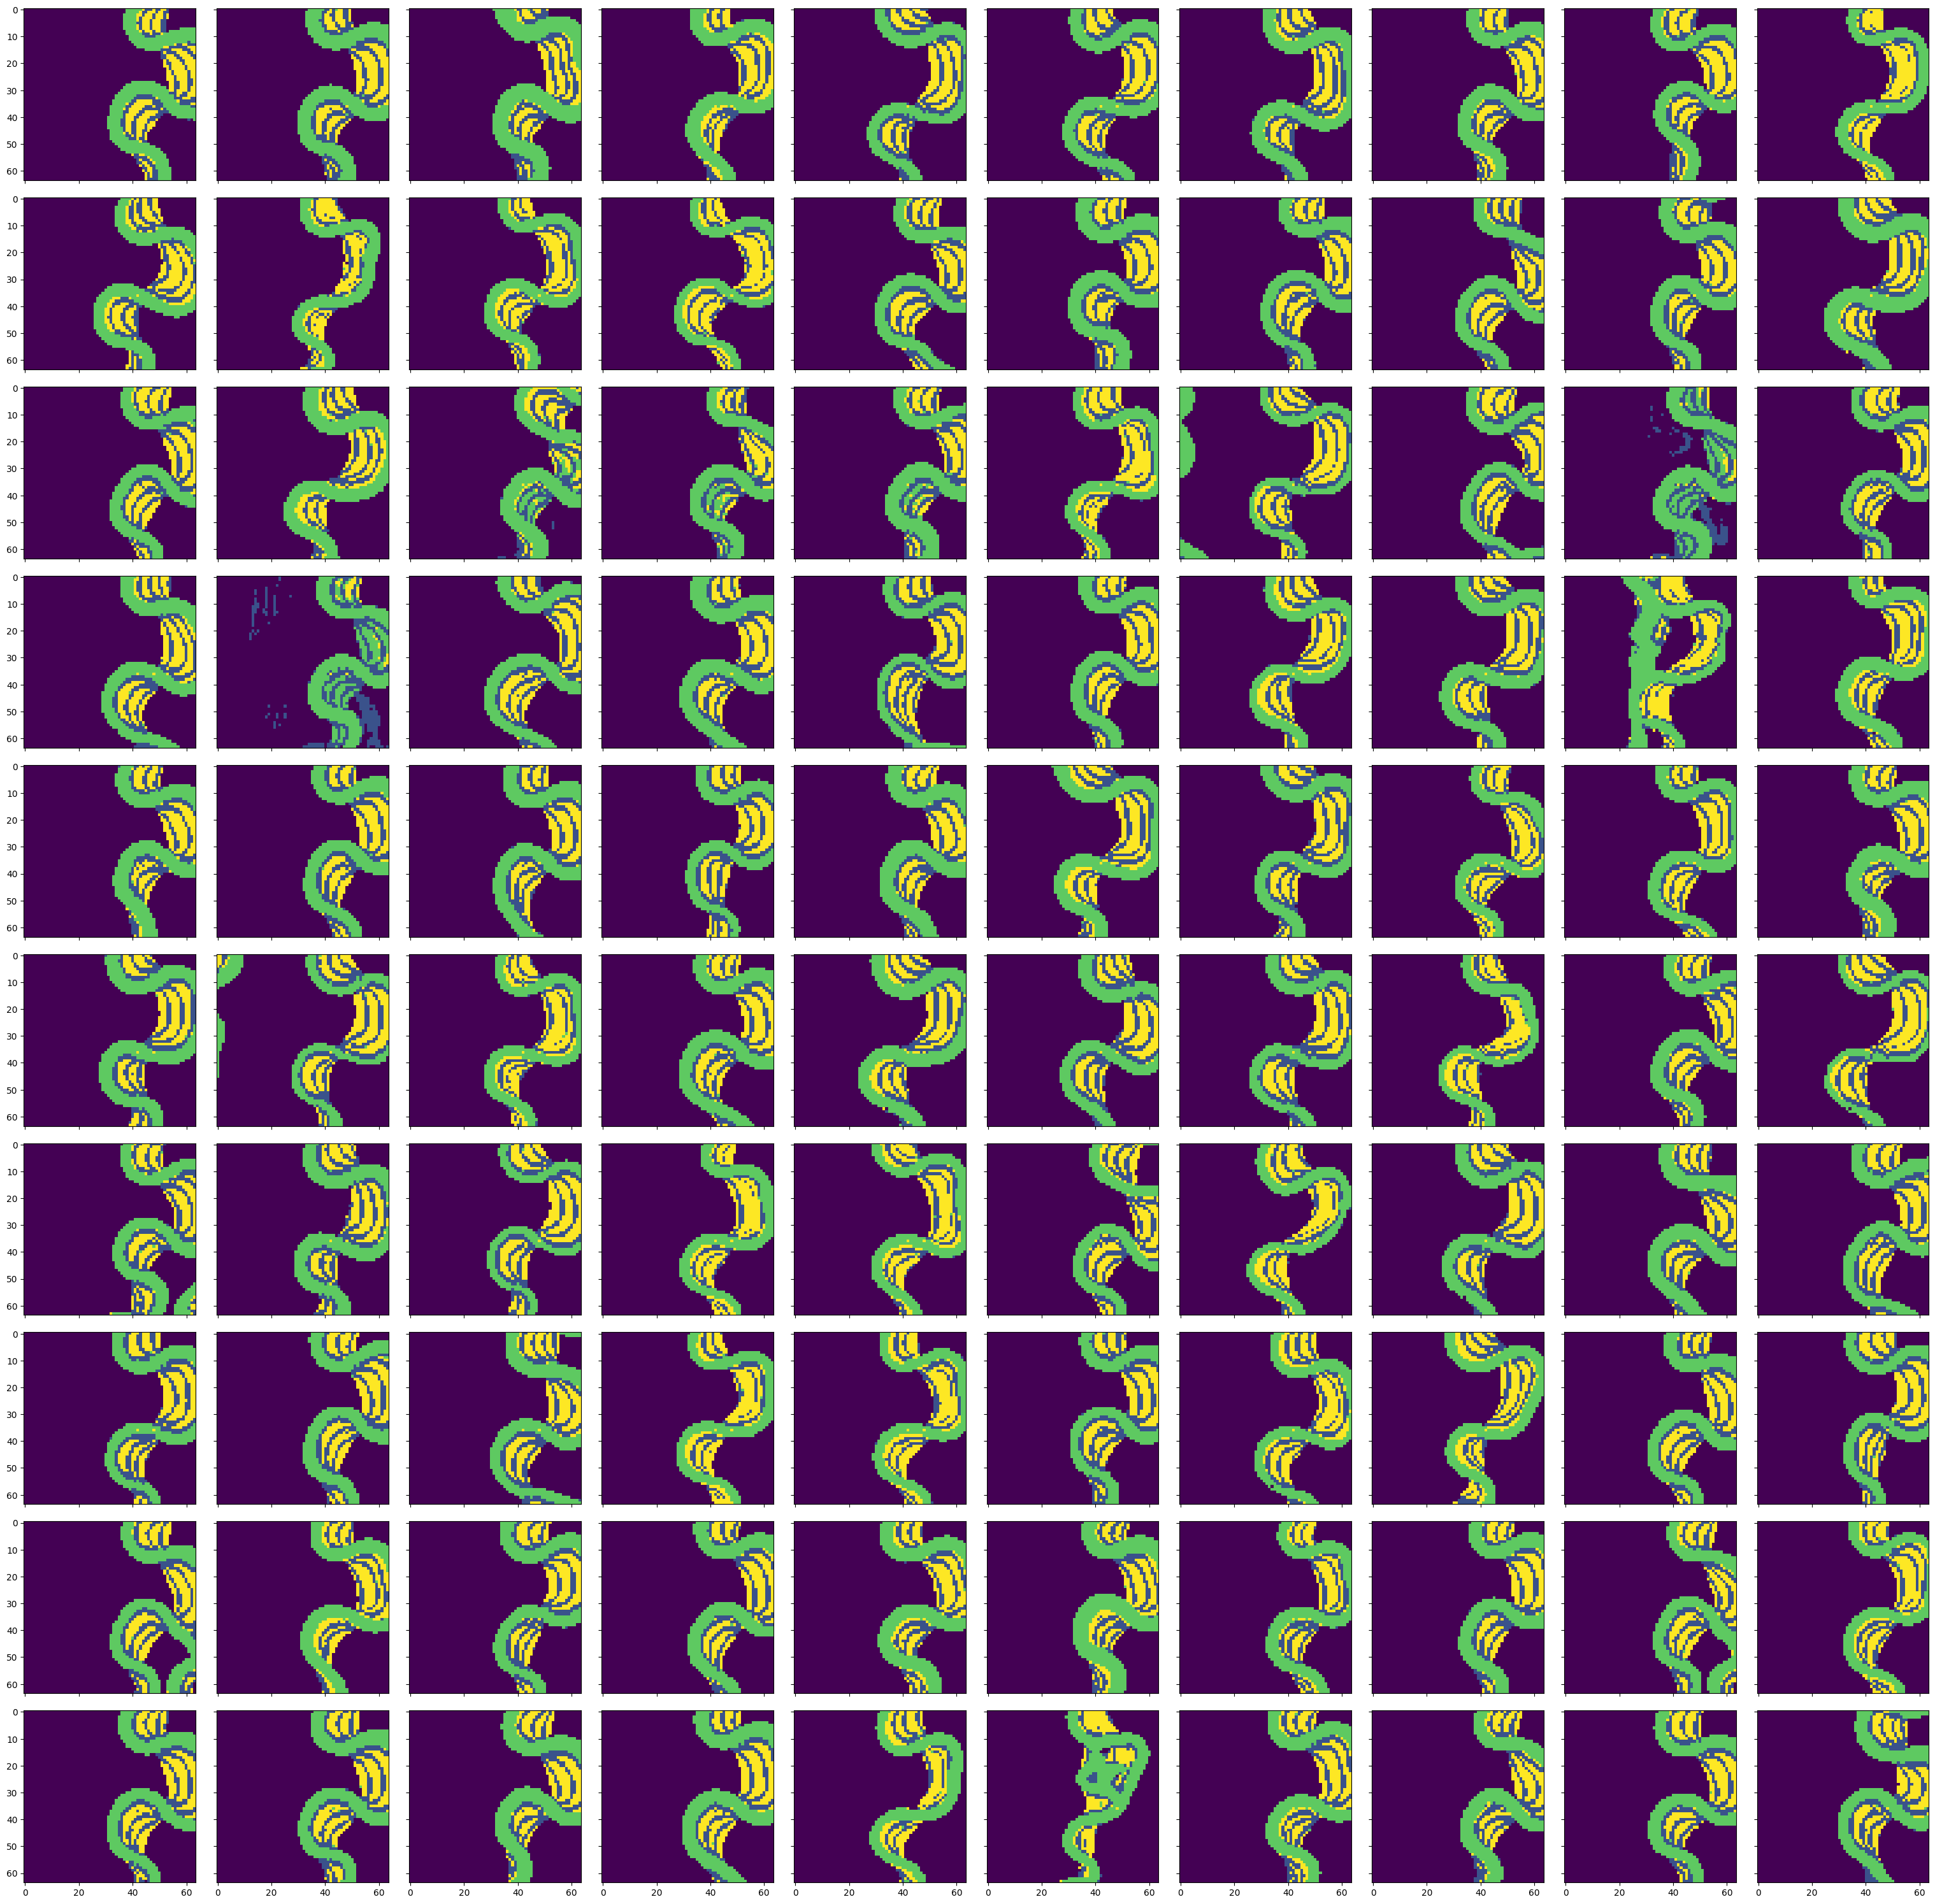

In [51]:
fig, ax = plt.subplots(10, 10, sharex='col', sharey='row')
fig.set_size_inches(30.5, 30, forward=True)

for i in range (10):
    for j in range(10):
        ax[i, j].imshow(Fakemodels_match_well[8,10,(i*10+j), :,:])
        
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.10, hspace=0.10)

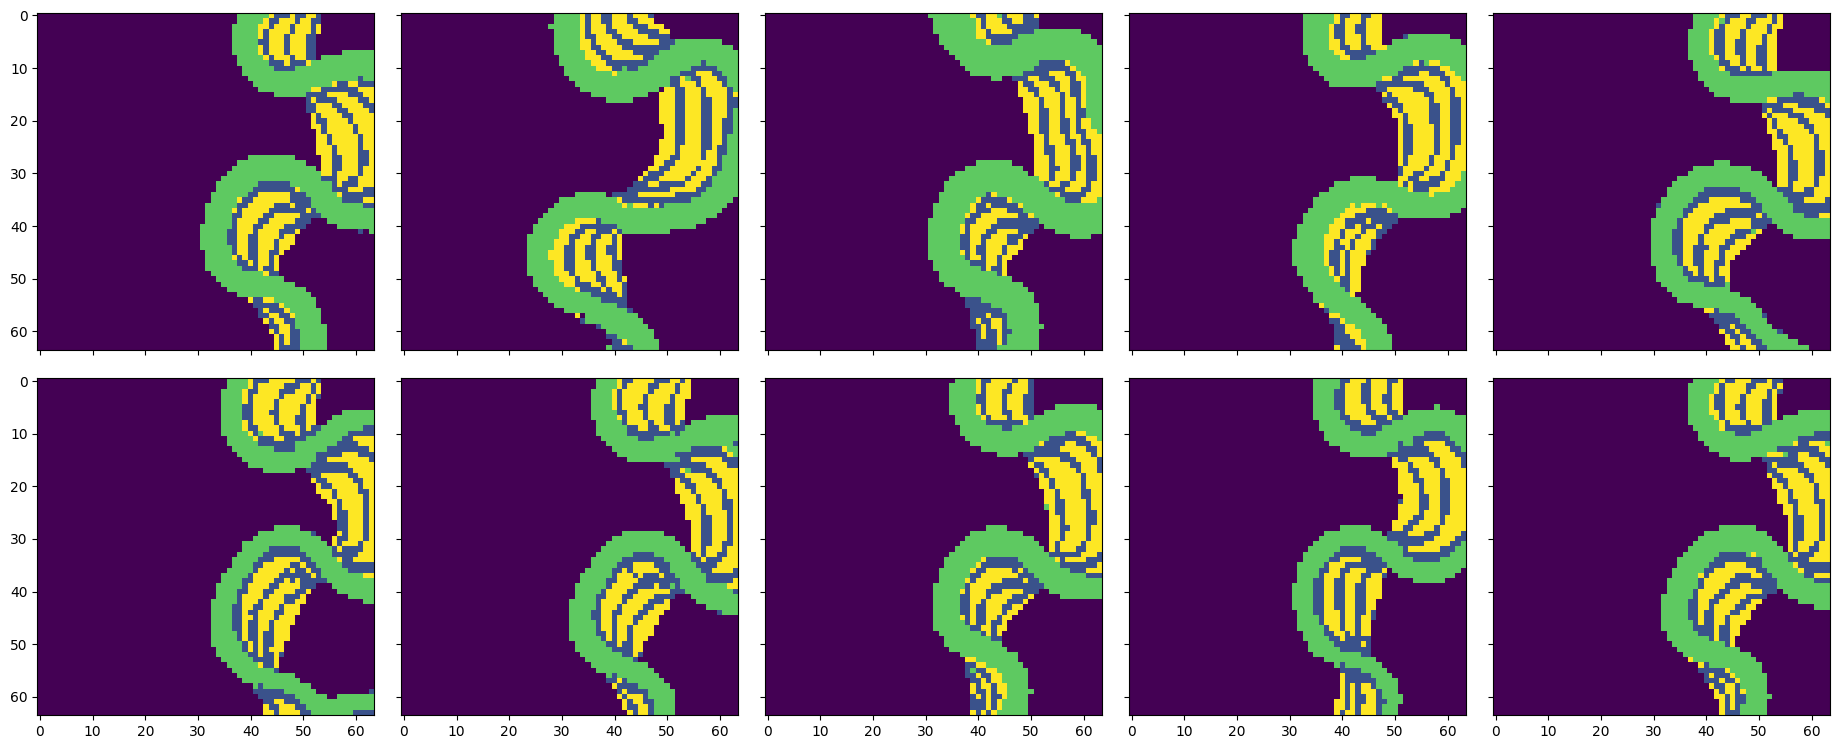

In [52]:
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row')
fig.set_size_inches(18.5, 7.5, forward=True)
  
for i in range (2):
    for j in range(5):
        ax[i, j].imshow(Fakemodels_match_well[8,10,(i*5+j), :,:])
        
ax[0, 1].imshow(Fakemodels_match_well[8,10, 54, :,:])
ax[0, 4].imshow(Fakemodels_match_well[8,10, 14, :,:])
ax[1, 0].imshow(Fakemodels_match_well[8,10, 27, :,:])
ax[1, 1].imshow(Fakemodels_match_well[8,10, 20, :,:])
ax[1, 3].imshow(Fakemodels_match_well[8,10, 43, :,:])
ax[1, 4].imshow(Fakemodels_match_well[8,10, 58, :,:])

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.08, hspace=0.08)

In [53]:
Fakemodels_match_well.shape

(9, 13, 500, 64, 64)

In [54]:
GAN_river = np.where((Fakemodels_match_well>0.2),1,0)

In [55]:
Mean_river = np.mean(GAN_river,axis=2)

In [56]:
Mean_river.shape

(9, 13, 64, 64)

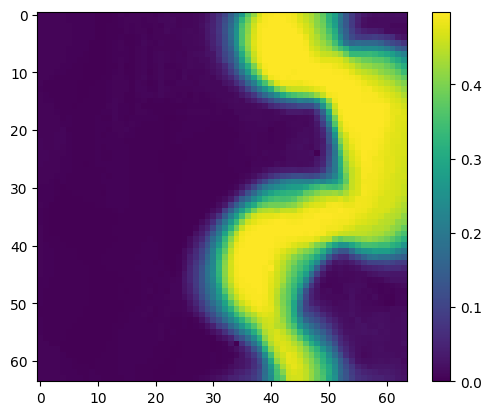

In [57]:
plt.imshow(Mean_river[8,10,:,:])
plt.colorbar()

In [58]:
prob_rlzs.shape

(40, 1, 64, 64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

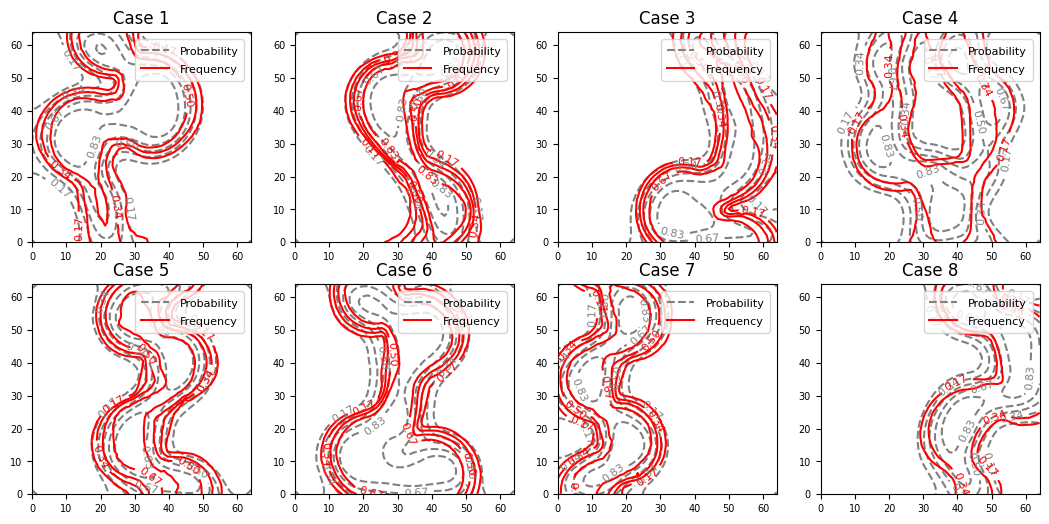

<Figure size 640x480 with 0 Axes>

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

x, y = np.meshgrid(np.linspace(0, 64, 64), np.linspace(0, 64, 64))

fig, axs = plt.subplots(2, 4, figsize=(13, 6))

pdf_values1 = prob_rlzs[19, 0,:,:]
pdf_values2 = Mean_river[8, 10,:,:]

for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=7)  
    ax.tick_params(axis='both', which='minor', labelsize=7) 

threshold = 0.17
levels = np.linspace(threshold, max(pdf_values1.max(), pdf_values2.max()), 6)

pdf_values1 = prob_rlzs[11, 0,::-1,:]
pdf_values2 = Mean_river[1, 10,::-1,:]
contour1 = axs[0, 0].contour(x, y, pdf_values1, levels=levels, linestyles='dashed',colors='gray')
contour2 = axs[0, 0].contour(x, y, pdf_values2, levels=levels, colors='red')
axs[0, 0].set_title('Case 1')
#axs[0, 0].grid(True)
axs[0, 0].clabel(contour1, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[0, 0].clabel(contour2, inline=True, fontsize=8, fmt='%.2f', zorder=3)
# Manually create a legend using ProxyArtist
legend_elements = [mlines.Line2D([], [], color='gray', linestyle='dashed', label='Probability'),
                   mlines.Line2D([], [], color='red', label='Frequency')]
legend=axs[0, 0].legend(handles=legend_elements)
for text in legend.get_texts():
    text.set_fontsize(8)

pdf_values1 = prob_rlzs[12, 0,::-1,:]
pdf_values2 = Mean_river[2, 4,::-1,:]
contour1 = axs[0, 1].contour(x, y, pdf_values1, levels=levels, linestyles='dashed',colors='gray')
contour2 = axs[0, 1].contour(x, y, pdf_values2, levels=levels, colors='red')
axs[0, 1].set_title('Case 2')
axs[0, 1].legend()
axs[0, 1].clabel(contour1, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[0, 1].clabel(contour2, inline=True, fontsize=8, fmt='%.2f', zorder=3)
# Manually create a legend using ProxyArtist
legend=axs[0, 1].legend(handles=legend_elements)
for text in legend.get_texts():
    text.set_fontsize(8)

pdf_values1 = prob_rlzs[17, 0,::-1,:]
pdf_values2 = Mean_river[3, 8,::-1,:]
contour1 = axs[0, 2].contour(x, y, pdf_values1, levels=levels, linestyles='dashed',colors='gray')
contour2 = axs[0, 2].contour(x, y, pdf_values2, levels=levels, colors='red')
axs[0, 2].set_title('Case 3')
axs[0, 2].legend()
axs[0, 2].clabel(contour1, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[0, 2].clabel(contour2, inline=True, fontsize=8, fmt='%.2f', zorder=3)
# Manually create a legend using ProxyArtist
legend=axs[0, 2].legend(handles=legend_elements)
for text in legend.get_texts():
    text.set_fontsize(8)

pdf_values1 = prob_rlzs[34, 0,::-1,:]
pdf_values2 = Mean_river[4, 8,::-1,:]
contour1 = axs[0, 3].contour(x, y, pdf_values1, levels=levels, linestyles='dashed',colors='gray')
contour2 = axs[0, 3].contour(x, y, pdf_values2, levels=levels, colors='red')
axs[0, 3].set_title('Case 4')
axs[0, 3].legend()
axs[0, 3].clabel(contour1, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[0, 3].clabel(contour2, inline=True, fontsize=8, fmt='%.2f', zorder=3)
# Manually create a legend using ProxyArtist
legend=axs[0, 3].legend(handles=legend_elements)
for text in legend.get_texts():
    text.set_fontsize(8)

pdf_values1 = prob_rlzs[5, 0,::-1,:]
pdf_values2 = Mean_river[5, 8,::-1,:]
contour1 = axs[1, 0].contour(x, y, pdf_values1, levels=levels, linestyles='dashed',colors='gray')
contour2 = axs[1, 0].contour(x, y, pdf_values2, levels=levels, colors='red')
axs[1, 0].set_title('Case 5')
axs[1, 0].legend()
axs[1, 0].clabel(contour1, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[1, 0].clabel(contour2, inline=True, fontsize=8, fmt='%.2f', zorder=3)
# Manually create a legend using ProxyArtist
legend=axs[1, 0].legend(handles=legend_elements)
for text in legend.get_texts():
    text.set_fontsize(8)

pdf_values1 = prob_rlzs[6, 0,::-1,:]
pdf_values2 = Mean_river[6, 2,::-1,:]
contour1 = axs[1, 1].contour(x, y, pdf_values1, levels=levels, linestyles='dashed',colors='gray')
contour2 = axs[1, 1].contour(x, y, pdf_values2, levels=levels, colors='red')
axs[1, 1].set_title('Case 6')
axs[1, 1].legend()
axs[1, 1].clabel(contour1, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[1, 1].clabel(contour2, inline=True, fontsize=8, fmt='%.2f', zorder=3)
# Manually create a legend using ProxyArtist
legend=axs[1, 1].legend(handles=legend_elements)
for text in legend.get_texts():
    text.set_fontsize(8)

pdf_values1 = prob_rlzs[38, 0,::-1,:]
pdf_values2 = Mean_river[7, 10,::-1,:]
contour1 = axs[1, 2].contour(x, y, pdf_values1, levels=levels, linestyles='dashed',colors='gray')
contour2 = axs[1, 2].contour(x, y, pdf_values2, levels=levels, colors='red')
axs[1, 2].set_title('Case 7')
axs[1, 2].legend()
axs[1, 2].clabel(contour1, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[1, 2].clabel(contour2, inline=True, fontsize=8, fmt='%.2f', zorder=3)
# Manually create a legend using ProxyArtist
legend = axs[1, 2].legend(handles=legend_elements)
for text in legend.get_texts():
    text.set_fontsize(8)

pdf_values1 = prob_rlzs[19, 0,::-1,:]
pdf_values2 = Mean_river[8, 10,::-1,:]
contour1 = axs[1, 3].contour(x, y, pdf_values1, levels=levels, linestyles='dashed',colors='gray')
contour2 = axs[1, 3].contour(x, y, pdf_values2, levels=levels, colors='red')
axs[1, 3].set_title('Case 8')
axs[1, 3].legend()
axs[1, 3].clabel(contour1, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[1, 3].clabel(contour2, inline=True, fontsize=8, fmt='%.2f', zorder=3)
# Manually create a legend using ProxyArtist
legend = axs[1, 3].legend(handles=legend_elements)

for text in legend.get_texts():
    text.set_fontsize(8)

plt.show()

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1.5)

In [60]:
pdf_values1 = prob_rlzs[11, 0, :, :]
pdf_values2 = Mean_river[1, 10, :, :]
contour1 = axs[0, 0].contour(x, y, pdf_values1, levels=levels, linestyles='dashed', colors='gray', label='PDF 1')
contour2 = axs[0, 0].contour(x, y, pdf_values2, levels=levels, colors='red', label='PDF 2')
axs[0, 0].set_title('Case 1')
axs[0, 0].clabel(contour1, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[0, 0].clabel(contour2, inline=True, fontsize=8, fmt='%.2f', zorder=3)
axs[0, 0].legend()

C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  after removing the cwd from sys.path.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [61]:
GAN_river = np.where((Fakemodels_match_well>0.2),1,0)

In [62]:
Fakemodels_match_well.shape

(9, 13, 500, 64, 64)

In [63]:
Mean_river = np.mean(GAN_river,axis=2)

In [64]:
Mean_river.shape

(9, 13, 64, 64)

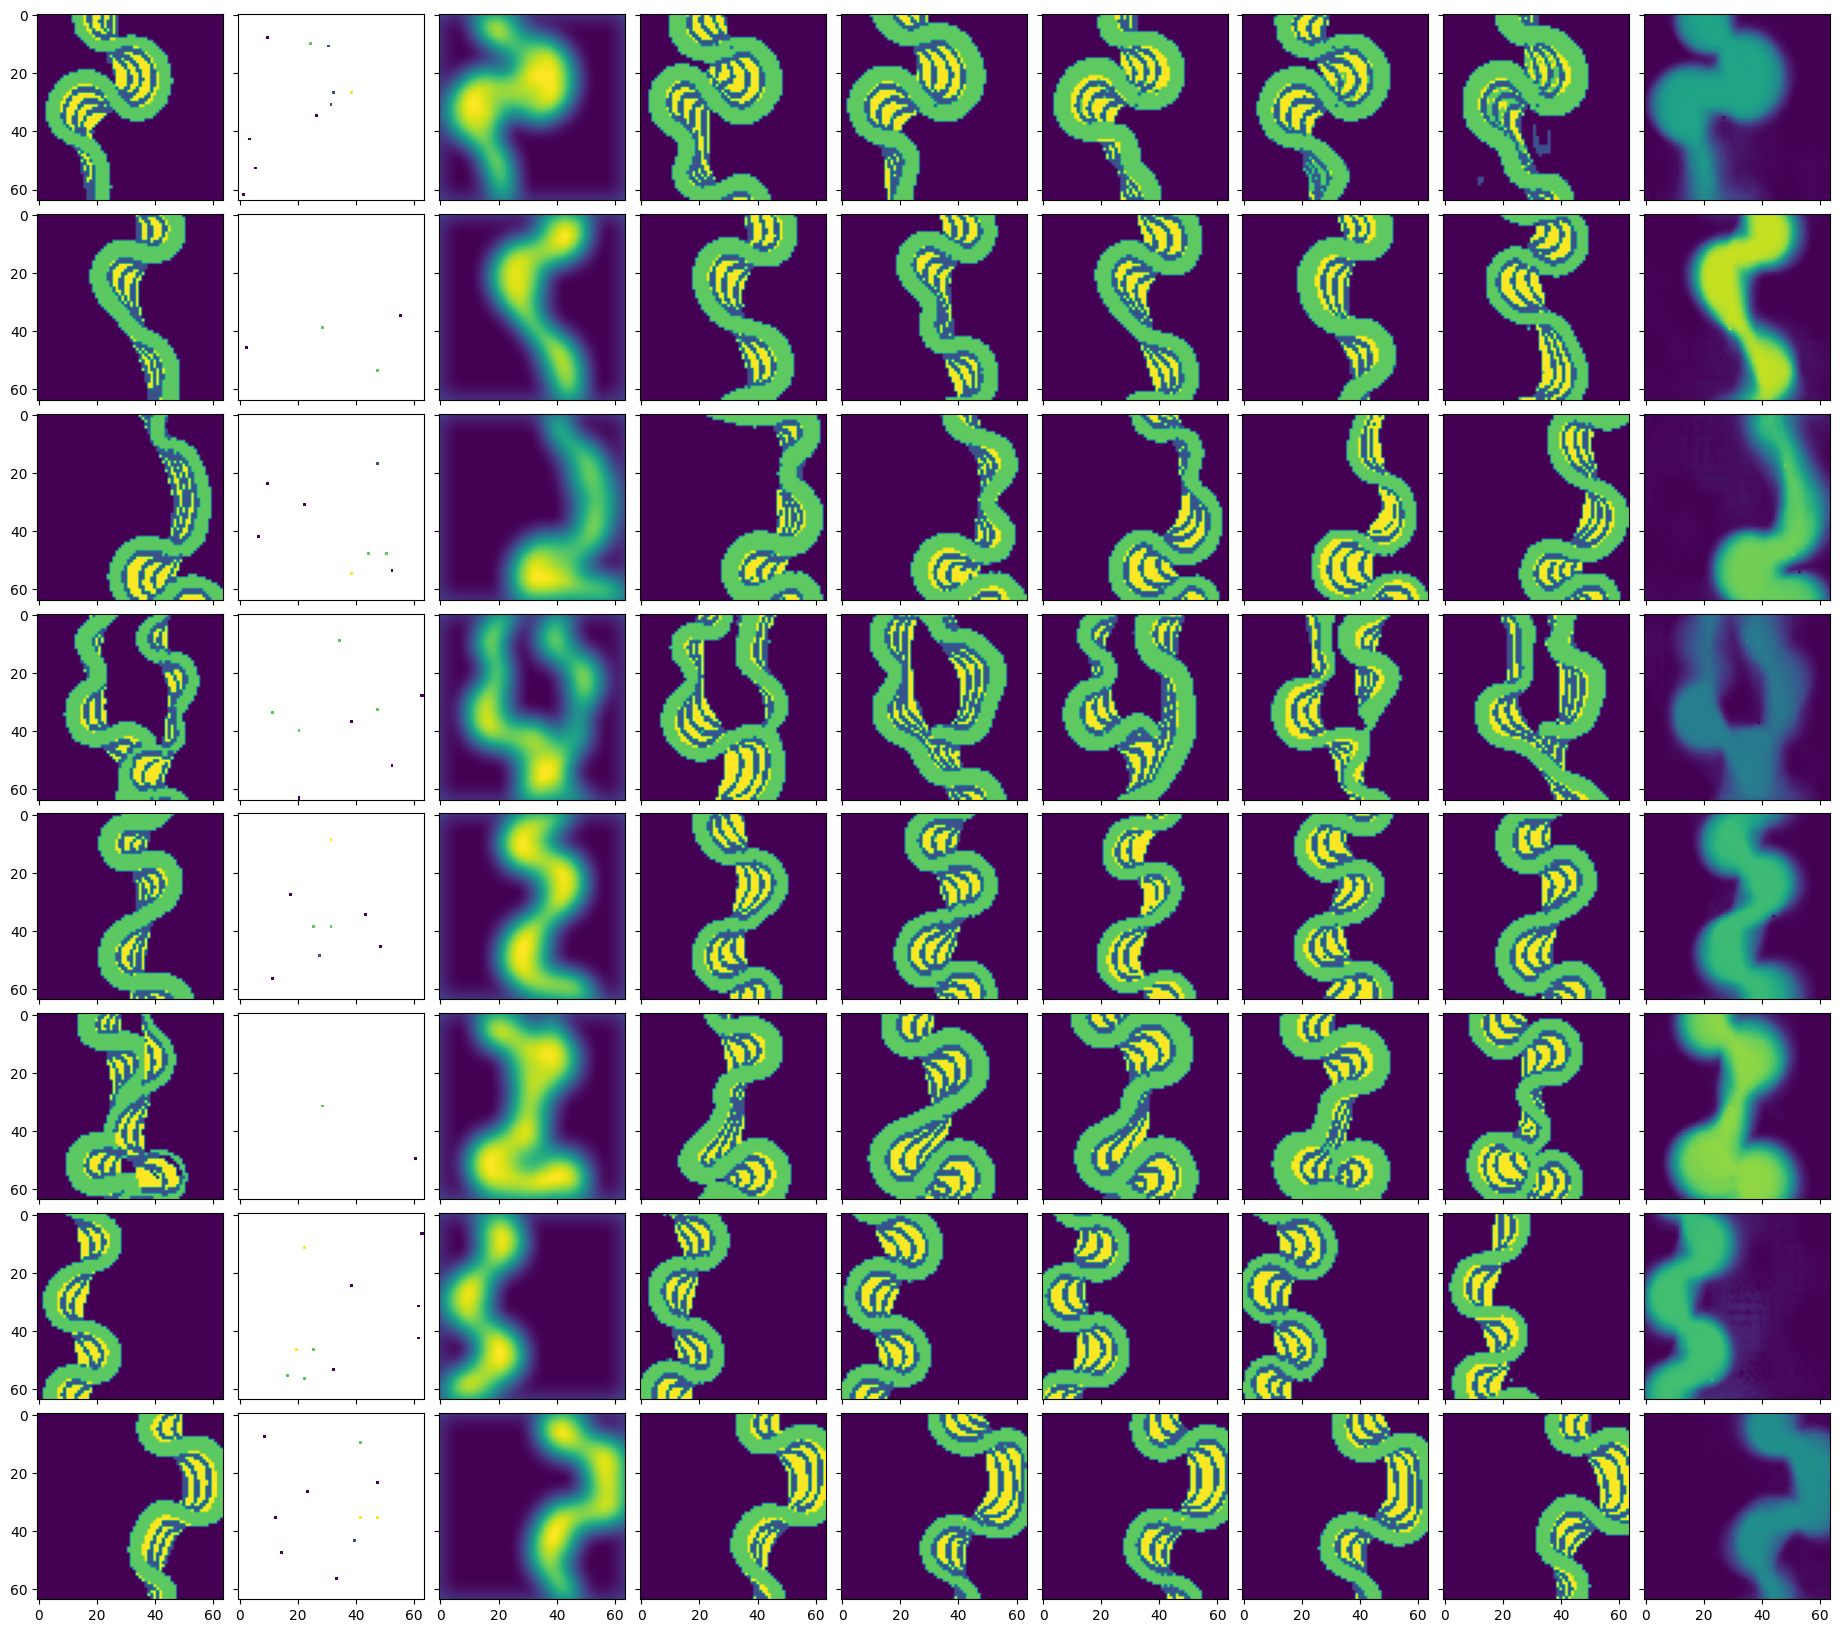

In [65]:
vmax = 1.0

fig, ax = plt.subplots(8, 9, sharex='col', sharey='row')
fig.set_size_inches(18.5, 16.5, forward=True)

for i in range(0, 8):
    ax[i, 0].imshow(realcubes_test[i,0,:,:])
    ax[i, 1].imshow(syn_wellfacies_input1_el_onechannel_mask[i,0,:,:], vmin=1, vmax=2)
    ax[i, 2].imshow(prob_rlzs[i,0, :,:], vmin=0, vmax=vmax)

for j in range(3, 8):
    ax[0, j].imshow(Fakemodels_match_well[1,10,j,:,:])
    ax[1, j].imshow(Fakemodels_match_well[2,4,j,:,:])
    ax[2, j].imshow(Fakemodels_match_well[3,8,j,:,:])
    ax[3, j].imshow(Fakemodels_match_well[4,8,j,:,:])
    ax[4, j].imshow(Fakemodels_match_well[5,8,j,:,:])
    ax[5, j].imshow(Fakemodels_match_well[6,2,j,:,:])
    ax[6, j].imshow(Fakemodels_match_well[7,10,j,:,:])
    ax[7, j].imshow(Fakemodels_match_well[8,10,j,:,:])
    
ax[0, 8].imshow(Mean_river[1,10,:,:], vmin=0, vmax=vmax)
ax[1, 8].imshow(Mean_river[2,4,:,:], vmin=0, vmax=vmax)
ax[2, 8].imshow(Mean_river[3,8,:,:], vmin=0, vmax=vmax)
ax[3, 8].imshow(Mean_river[4,8,:,:], vmin=0, vmax=vmax)
ax[4, 8].imshow(Mean_river[5,8,:,:], vmin=0, vmax=vmax)
ax[5, 8].imshow(Mean_river[6,2,:,:], vmin=0, vmax=vmax)
ax[6, 8].imshow(Mean_river[7,10,:,:], vmin=0, vmax=vmax)
ax[7, 8].imshow(Mean_river[8,10,:,:], vmin=0, vmax=vmax)

ax[0, 0].imshow(realcubes_test[11,0,:,:])
ax[0, 1].imshow(syn_wellfacies_input1_el_onechannel_mask[11,0,:,:], vmin=1, vmax=2)
ax[0, 2].imshow(prob_rlzs[11,0, :,:], vmin=0, vmax=vmax)

ax[1, 0].imshow(realcubes_test[12,0,:,:])
ax[1, 1].imshow(syn_wellfacies_input1_el_onechannel_mask[12,0,:,:], vmin=1, vmax=2)
ax[1, 2].imshow(prob_rlzs[12,0, :,:], vmin=0, vmax=vmax)

ax[2, 0].imshow(realcubes_test[17,0,:,:])
ax[2, 1].imshow(syn_wellfacies_input1_el_onechannel_mask[17,0,:,:], vmin=1, vmax=2)
ax[2, 2].imshow(prob_rlzs[17,0, :,:], vmin=0, vmax=vmax)

ax[3, 0].imshow(realcubes_test[34,0,:,:])
ax[3, 1].imshow(syn_wellfacies_input1_el_onechannel_mask[34,0,:,:], vmin=1, vmax=2)
ax[3, 2].imshow(prob_rlzs[34,0, :,:], vmin=0, vmax=vmax)

ax[4, 0].imshow(realcubes_test[5,0,:,:])
ax[4, 1].imshow(syn_wellfacies_input1_el_onechannel_mask[5,0,:,:], vmin=1, vmax=2)
ax[4, 2].imshow(prob_rlzs[5,0, :,:], vmin=0, vmax=vmax)

ax[5, 0].imshow(realcubes_test[6,0,:,:])
ax[5, 1].imshow(syn_wellfacies_input1_el_onechannel_mask[6,0,:,:], vmin=1, vmax=2)
ax[5, 2].imshow(prob_rlzs[6,0, :,:], vmin=0, vmax=vmax)

ax[6, 0].imshow(realcubes_test[38,0,:,:])
ax[6, 1].imshow(syn_wellfacies_input1_el_onechannel_mask[38,0,:,:], vmin=1, vmax=2)
ax[6, 2].imshow(prob_rlzs[38,0, :,:], vmin=0, vmax=vmax)

ax[7, 0].imshow(realcubes_test[19,0,:,:])
ax[7, 1].imshow(syn_wellfacies_input1_el_onechannel_mask[19,0,:,:], vmin=1, vmax=2)
ax[7, 2].imshow(prob_rlzs[19,0, :,:], vmin=0, vmax=vmax)
            
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.08, hspace=0.04)